In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

Now it's time for another guided example. This time we're going to look at recipes. Specifically we'll use the epicurious dataset, which has a collection of recipes, key terms and ingredients, and their ratings.

What we want to see is if we can use the ingredient and keyword list to predict the rating. For someone writing a cookbook this could be really useful information that could help them choose which recipes to include because they're more likely to be enjoyed and therefore make the book more likely to be successful.

In [2]:
raw_data = pd.read_csv('epi_r.csv.zip')

In [3]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

We learn a few things from this analysis. From a ratings perspective, there are just over 20,000 recipes with an average rating of 3.71. What is interesting is that the 25th percentile is actually above the mean. This means there is likely some kind of outlier population. This makes sense when we think about reviews: some bad recipes may have very few very low reviews.

Let's validate the idea a bit further with a histogram.

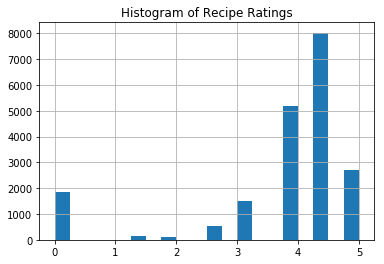

In [4]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

So a few things are shown in this histogram. Firstly there are sharp discontinutities. We don't have continuous data. No recipe has a 3.5 rating, for example. Also we see the anticipated increase at 0.

Let's try a naive approach again, this time using SVM Regressor. But first, we'll have to do a bit of data cleaning.

In [5]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

What we can see right away is that nutrition information is not available for all goods. Now this would be an interesting data point, but let's focus on ingredients and keywords right now. So we'll actually drop the whole columns for calories, protein, fat, and sodium. We'll come back to nutrition information later.

In [7]:
svr = SVR()
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
Y = raw_data.rating
svr.fit(X,Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

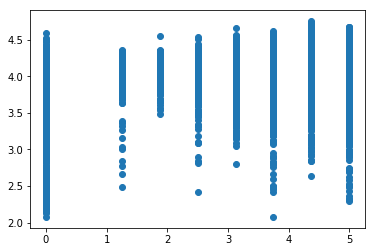

In [8]:
plt.scatter(Y, svr.predict(X))

In [10]:
svr.score(X, Y)

0.038565706512988962

In [11]:
cross_val_score(svr, X, Y, cv=5)

array([ 0.01818511,  0.026411  ,  0.03037705,  0.01957949,  0.02451197])

Oh dear, so this did seem not to work very well. In fact it is remarkably poor. Now there are many things that we could do here. 

Firstly the overfit is a problem, even though it was poor in the first place. We could go back and clean up our feature set. There might be some gains to be made by getting rid of the noise.

We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.

Lastly, we could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values.

__And that is your challenge.__

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

Good luck!

When you've finished that, also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so?

There is. Several things in fact, but most glaringly is that we don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are more likely to give high reviews.

After all, people who eat chocolate _might_ just be happier people.

## SVM Classification Challenge

My first step is to simplify and clean up my dataset. I begin by finding the features that are used infrequently. 

In [7]:
# Reloading my X and Y variables from earlier. 
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
Y = raw_data.rating

In [8]:
# Find the columns that are used less than 300 times in the dataset. Then append those column names to a list. 
uncommon_features = []
for i in X.columns:
    if X[i][X[i] == 1].count() < 300:
        uncommon_features.append(i)

In [9]:
# Drop those uncommon features from the dataset. 
X = X.drop(uncommon_features, 1)

In [11]:
# Recode the 'rating' column to binary for values that are less than 4.
Y = np.where(Y<=4, 0, 1)

Now I am going to create a new data frame where I join the simplified features and the now binary rating column together. This will allow me to group by the ratings so that I can compare the frequency of the features between the two groups. If a feature is equally used for the positive and negative reviewed recipes then it won't be very helpful in differentiating the groups. So after grouping by the frequency of the features in each group, I find the difference for each feature between the two groups. This allows me to set a thresh hold for the features that have the most difference between positive and negative reviewed recipes. I then limit my original dataset to these features that appear to have the most difference for reviewed recipes.

In [32]:
# A new data frame where I join the simplified features and the now binary rating column
clean_data = pd.DataFrame(X)
clean_data['rating'] = Y

In [34]:
# Group by the ratings so that the frequency of the features between the two groups can be compared.
averageFeatures = clean_data.groupby('rating').mean()
averageFeatures

,alcoholic,backyard bbq,bake,bon appétit,christmas,cocktail,cocktail party,dessert,dinner,drink,...,quick & easy,roast,side,soy free,summer,thanksgiving,tree nut free,vegan,vegetable,wheat/gluten-free
rating,,,,,,,,,,,,,,,,,,,,,
0,0.058192,0.035967,0.206141,0.414537,0.038866,0.025660,0.073438,0.163303,0.112089,0.074404,...,0.282800,0.047670,0.164161,0.368692,0.200021,0.054005,0.326712,0.104574,0.113378,0.237707
1,0.027286,0.056156,0.232166,0.511641,0.063047,0.013131,0.043770,0.191097,0.154684,0.036692,...,0.254982,0.081579,0.151052,0.433414,0.213075,0.088936,0.372602,0.081673,0.096014,0.250698


In [18]:
# The difference for each feature between the two groups.
averageFeatures.diff()

,alcoholic,almond,appetizer,apple,backyard bbq,bacon,bake,basil,bean,beef,...,vegan,vegetable,vegetarian,vinegar,walnut,wheat/gluten-free,white wine,winter,yogurt,turkey
rating,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.030906,0.008073,0.005671,0.003479,0.020188,0.006948,0.026025,0.00109,-0.001401,0.009364,...,-0.022901,-0.017364,-0.006232,0.005541,0.006097,0.012992,0.003851,0.008313,-0.009573,0.009986


In [31]:
# Setting a thresh hold for the features that have the most difference between the two groups.
averageFeatures.diff()[(averageFeatures.diff() >= 0.012) | (averageFeatures.diff() <= -0.012)]

,alcoholic,almond,appetizer,apple,backyard bbq,bacon,bake,basil,bean,beef,...,vegan,vegetable,vegetarian,vinegar,walnut,wheat/gluten-free,white wine,winter,yogurt,turkey
rating,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.030906,NaN,NaN,NaN,0.020188,NaN,0.026025,NaN,NaN,NaN,...,-0.022901,-0.017364,NaN,NaN,NaN,0.012992,NaN,NaN,NaN,NaN


In [23]:
# Drop the columns that have null values in both rows of the feature. The number of feature has dropped to 34. 
averageFeatures.diff()[(averageFeatures.diff() >= 0.012) | (averageFeatures.diff() <= -0.012)].dropna(axis=1, how='all')

,alcoholic,backyard bbq,bake,bon appétit,christmas,cocktail,cocktail party,dessert,dinner,drink,...,quick & easy,roast,side,soy free,summer,thanksgiving,tree nut free,vegan,vegetable,wheat/gluten-free
rating,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.030906,0.020188,0.026025,0.097104,0.024181,-0.012529,-0.029668,0.027794,0.042595,-0.037712,...,-0.027818,0.033909,-0.013109,0.064722,0.013054,0.034932,0.045889,-0.022901,-0.017364,0.012992


In [19]:
new_data = averageFeatures.diff()[(averageFeatures.diff() >= 0.012) | (averageFeatures.diff() <= -0.012)].dropna(axis=1, how='all')

In [24]:
# Loop through these 34 chosen features and make of list of the column names. 
chosen_features = []
for each in new_data:
    chosen_features.append(each)

In [25]:
# Reduce my original dataset to these features
X = X[chosen_features]    

In [27]:
# Now run my support vector machine classification model on my binary ratings and reduced feature dataset. 
svc = SVC()
svc.fit(X, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [28]:
# The accuracy from the SVC model. 
svc.score(X, Y)

0.58951725513664477

In [29]:
# The cross validated accuracy for the SVC model 
cross_val_score(svc, X, Y, cv=5)

array([ 0.5771628 ,  0.58688606,  0.57217651,  0.58229426,  0.58767773])

In [30]:
# This crosstab shows that failed predictions seem to be even for both groups. 
pd.crosstab(Y, svc.predict(X))

col_0,0,1
row_0,,
0,3275,6039
1,2192,8546


Some of the main bias issues with this dataset is it not a randomly collected sample of recipes or recipe reviews. Since it is not random, this model will have very limited ability to be used on other recipe review datasets. Also, we can see from the first histogram that the large majority of reviews are positive. This majority of positive reviews will bias the model to being able to predict positive over negative reviews. 